# **Sentimen Analisis Review Game di Play Store - Evil Nun**

## Import Library

In [181]:
from google_play_scraper import app, reviews, Sort, reviews_all
import pandas as pd
from numpy import ma
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pd.options.mode.chained_assignment = None
import numpy as np

seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import datetime as dt
import re
import string
import csv
import requests
from gensim.models import Word2Vec
from io import StringIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/refanzzzz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/refanzzzz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/refanzzzz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Scraping Dataset

In [54]:
# Mengambil semua ulasan dari game dengan ID 'com.keplerians.evilnun' di Google Play Store
# Proses scraping meungkin memerlukan waktu beberapa saat tergantung pada jumlah ulasan yang ada
scraper_view = reviews_all(
    'com.keplerians.evilnun',  # ID aplikasi
    lang='id',  # Bahasa ulasan (default: 'en')
    country='id',  # Negara (default: 'en')
    sort=Sort.MOST_RELEVANT,  # Urutan ulasan (default: Sort.MOST_RELEVANT)
    count=12000  # Jumlah maksimum ulasan yang ingin diambil
)

## Loading Dataset

In [55]:
# Membuat DataFrame hasil dari scraping
# Melakukan slicing sebanyak 10000 data, karena reviews_all mengabaikan parameter count dan mengambil seluruh ulasan
game_reviews_df = pd.DataFrame(scraper_view[:12000])

# Mengkonversi DataFrame menjadi berkas CSV
game_reviews_df.to_csv('evil_nun_reviews.csv', index=False)

In [56]:
# Membuat DataFrame dari hasil scrape_view
game_reviews_df = pd.DataFrame(scraper_view[:12000])

# Menghitung jumlah baris dan kolom pada DataFrame
reviews_count, columns_count = game_reviews_df.shape

print("Jumlah ulasan: ", reviews_count)
print("Jumlah kolom: ", columns_count)

Jumlah ulasan:  12000
Jumlah kolom:  11


In [57]:
# Menampilkan lima baris pertama dari DataFrame game_reviews_df
game_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,55ed02a9-0ed3-4012-9cff-3ccd6a558172,Alif Fathan,https://play-lh.googleusercontent.com/a/ACg8oc...,Terima kasih untuk Keplerians/Developer yg tel...,5,10,1.9.1,2025-04-09 15:56:37,None,NaT,1.9.1
1,4e4b81f5-7e49-4c20-8b59-7e8d05546b92,Maura Qory Muzdalifa,https://play-lh.googleusercontent.com/a-/ALV-U...,"jujur game ini seru bgt😖🙏, tapi masalah nya in...",5,41,1.9.1,2025-03-23 13:52:19,None,NaT,1.9.1
2,cb2d5f74-8a08-4c84-8bd0-172e9ad2d721,eko setiawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Dari 2019 sampai 2025 (1.8.9) game ini udah ba...,2,37,1.9.0,2025-01-31 17:01:13,Hi! This issue has been just fixed 🔧 You can u...,2025-03-25 18:30:55,1.9.0
3,e331edd9-69d5-41b3-bdfc-3781dfd139b5,Jhosu Tumanggor,https://play-lh.googleusercontent.com/a-/ALV-U...,"ngebug nya banyak,pas topeng nya sudah terkump...",3,1,1.9.1,2025-03-18 21:22:20,None,NaT,1.9.1
4,df9b4228-d28a-4df5-a02c-9316a7c32195,Keisya Kamilla,https://play-lh.googleusercontent.com/a/ACg8oc...,Terima kasih kepada developer Keplerians karen...,5,14,1.9.1,2025-03-21 20:29:49,Hi! This issue has been just fixed 🔧 You can u...,2025-03-18 20:49:27,1.9.1


## Cleaning Dataset

In [58]:
# Menampilkan informasi tentang DataFrame game_reviews_df
game_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              12000 non-null  object        
 1   userName              12000 non-null  object        
 2   userImage             12000 non-null  object        
 3   content               12000 non-null  object        
 4   score                 12000 non-null  int64         
 5   thumbsUpCount         12000 non-null  int64         
 6   reviewCreatedVersion  4298 non-null   object        
 7   at                    12000 non-null  datetime64[ns]
 8   replyContent          253 non-null    object        
 9   repliedAt             253 non-null    datetime64[ns]
 10  appVersion            4298 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.0+ MB


In [59]:
# Melakukan drop beberapa kolom dari DataFrame game_reviews_df
clean_df = game_reviews_df.drop(columns=['reviewCreatedVersion', 'repliedAt', 'replyContent', 'appVersion'])

# Menampilkan informasi tentang DataFrame clean_df
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   reviewId       12000 non-null  object        
 1   userName       12000 non-null  object        
 2   userImage      12000 non-null  object        
 3   content        12000 non-null  object        
 4   score          12000 non-null  int64         
 5   thumbsUpCount  12000 non-null  int64         
 6   at             12000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 656.4+ KB


In [60]:
# Mengecek apakah ada data yang duplikat
duplicate_count = clean_df.duplicated().sum()
print("Jumlah duplikasi: ", duplicate_count)

Jumlah duplikasi:  0


## Preprocessing Text

In [61]:
# Membuat helper function untuk membersihkan teks
def cleaning_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  # Menghapus hashtag
    text = re.sub(r'RT[\s]+', '', text)  # Menghapus retweet
    text = re.sub(r'http\S+', '', text)  # Menghapus link
    text = re.sub(r'[0-9]+', '', text)  # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text)  # Menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ')  # Mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation))  # Menghapus tanda baca
    text = text.strip(' ')  # Menghapus karakter awal dan akhir

    return text

In [62]:
# Membuat helper function untuk mengubah teks menjadi huruf kecil
def casefolding_text(text):
    text = text.lower()
    return text

In [63]:
# Memecah atau membagi string, teks menjadi daftar token
def tokenizing_text(text):
    text = word_tokenize(text)
    return text

In [64]:
# Menghapus stopwords dalam teks
def filtering_text(text):
    list_stopwords = set(stopwords.words('indonesian'))
    list_stopwords1 = set(stopwords.words('english'))
    list_stopwords.update(list_stopwords1)
    list_stopwords.update(
        ['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', "di", "ga", "ya", "gaa", "loh", "kah", "woi", "woii", "woy",
         "anjir", "njir"])

    filtered = []

    for txt in text:
        if txt not in list_stopwords:
            filtered.append(txt)

    text = filtered
    return text

In [65]:
# Membuat helper function untuk mengubah kata menjadi kata dasar
def stemming_text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [66]:
# Mengkonversi list kata menjadi kalimat
def to_sentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [67]:
# Menghapus angka pada teks
def remove_number(text):
    text_without_number = ''.join([char for char in text if not char.isdigit()])
    return text_without_number


In [68]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar",
              "bgt": "banget", "maks": "maksimal", "plisss": "tolong", "bgttt": "banget", "indo": "indonesia",
              "bgtt": "banget", "ad": "ada", "rv": "redvelvet", "plis": "tolong", "pls": "tolong", "cr": "sumber",
              "cod": "bayar ditempat", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja",
              "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku",
              "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing",
              "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya",
              "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam",
              "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu",
              "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan",
              "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur",
              "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan",
              "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan",
              "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana",
              "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh",
              "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah",
              "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat",
              "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa",
              "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur",
              "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan",
              "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi",
              "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut",
              "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja",
              "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep",
              "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi",
              "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek",
              "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor",
              "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh",
              "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan",
              "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana",
              "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan",
              "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana",
              "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian",
              "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya",
              "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile",
              "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi",
              "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa",
              "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja",
              "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas",
              "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana",
              "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini",
              "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya",
              "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok",
              "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan",
              "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong",
              "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah",
              "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion",
              "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi",
              "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga",
              "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar",
              "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur",
              "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan",
              "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah",
              "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya",
              "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional",
              "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau",
              "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat",
              "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau",
              "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus",
              "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin",
              "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat",
              "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu",
              "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah",
              "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan",
              "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi",
              "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan",
              "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa",
              "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu",
              "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih",
              "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa",
              "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan",
              "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi",
              "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau",
              "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman",
              "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional",
              "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan",
              "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana",
              "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ",
              "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak",
              "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta",
              "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil",
              "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan",
              "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim",
              "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok",
              "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan",
              "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini",
              "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng",
              "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi",
              "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu",
              "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic",
              "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah",
              "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala",
              "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada",
              "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah",
              "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani",
              "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang",
              "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin",
              "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren",
              "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti",
              "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi",
              "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi",
              "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah",
              "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya",
              "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa",
              "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya",
              "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip",
              "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat",
              "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik",
              "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit",
              "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat",
              "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf",
              "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti",
              "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit",
              "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi",
              "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir",
              "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu",
              "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne",
              "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman",
              "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai",
              "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih",
              "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu",
              "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah",
              "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu",
              "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur",
              "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat",
              "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya",
              "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya",
              "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord",
              "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja",
              "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja",
              "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa",
              "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin",
              "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik",
              "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar",
              "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas",
              "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden",
              "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah",
              "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar",
              "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis",
              "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur",
              "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli",
              "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak",
              "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh",
              "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa",
              "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan",
              "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan",
              "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep",
              "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek",
              "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek",
              "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck",
              "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut",
              "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu",
              "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu",
              "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa",
              "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo",
              "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus",
              "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh",
              "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali",
              "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah",
              "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi",
              "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji",
              "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian",
              "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak",
              "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten",
              "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar",
              "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti",
              "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan",
              "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan",
              "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian",
              "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus",
              "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer",
              "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada",
              "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya",
              "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan",
              "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur",
              "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat",
              "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh",
              "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu",
              "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih",
              "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main",
              "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan",
              "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus",
              "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras",
              "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede",
              "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing",
              "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik",
              "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf",
              "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik",
              "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut",
              "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa",
              "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa",
              "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng",
              "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat",
              "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut",
              "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan",
              "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari",
              "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok",
              "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas",
              "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi",
              "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal",
              "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya",
              "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya",
              "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa",
              "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu",
              "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon",
              "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal",
              "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang",
              "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman",
              "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi",
              "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya",
              "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal",
              "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik",
              "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras",
              "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat",
              "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama",
              "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu",
              "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang",
              "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut",
              "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu",
              "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang",
              "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah",
              "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak",
              "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi",
              "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin"}

In [69]:
# Mengubah kata slang menjadi formal
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [70]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaning_text)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di dalam kolom 'text_casefolding'
clean_df['text_casefolding'] = clean_df['text_clean'].apply(casefolding_text)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefolding'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di kolom 'text_tokenizing'
clean_df['text_tokenizing'] = clean_df['text_slangwords'].apply(tokenizing_text)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopwords'] = clean_df['text_tokenizing'].apply(filtering_text)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di kolom 'text_to_sentence'
clean_df['text_final'] = clean_df['text_stopwords'].apply(to_sentence)

In [71]:
# Menampilkan DataFrame clean_df setelah dilakukan pemrosesan teks
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopwords,text_final
0,55ed02a9-0ed3-4012-9cff-3ccd6a558172,Alif Fathan,https://play-lh.googleusercontent.com/a/ACg8oc...,Terima kasih untuk Keplerians/Developer yg tel...,5,10,2025-04-09 15:56:37,Terima kasih untuk KepleriansDeveloper yg tela...,terima kasih untuk kepleriansdeveloper yg tela...,terima kasih untuk kepleriansdeveloper yang te...,"[terima, kasih, untuk, kepleriansdeveloper, ya...","[terima, kasih, kepleriansdeveloper, evil, nun...",terima kasih kepleriansdeveloper evil nun bagu...
1,4e4b81f5-7e49-4c20-8b59-7e8d05546b92,Maura Qory Muzdalifa,https://play-lh.googleusercontent.com/a-/ALV-U...,"jujur game ini seru bgt😖🙏, tapi masalah nya in...",5,41,2025-03-23 13:52:19,jujur game ini seru bgt tapi masalah nya ini k...,jujur game ini seru bgt tapi masalah nya ini k...,jujur game ini seru banget tapi masalah nya in...,"[jujur, game, ini, seru, banget, tapi, masalah...","[jujur, game, seru, banget, pas, offline, load...",jujur game seru banget pas offline loadingnya ...
2,cb2d5f74-8a08-4c84-8bd0-172e9ad2d721,eko setiawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Dari 2019 sampai 2025 (1.8.9) game ini udah ba...,2,37,2025-01-31 17:01:13,Dari sampai game ini udah bagus banget tapi...,dari sampai game ini udah bagus banget tapi...,dari sampai game ini sudah bagus banget tapi k...,"[dari, sampai, game, ini, sudah, bagus, banget...","[game, bagus, banget, gamenya, stuck, loading,...",game bagus banget gamenya stuck loading scene ...
3,e331edd9-69d5-41b3-bdfc-3781dfd139b5,Jhosu Tumanggor,https://play-lh.googleusercontent.com/a-/ALV-U...,"ngebug nya banyak,pas topeng nya sudah terkump...",3,1,2025-03-18 21:22:20,ngebug nya banyakpas topeng nya sudah terkumpu...,ngebug nya banyakpas topeng nya sudah terkumpu...,ngebug nya banyakpas topeng nya sudah terkumpu...,"[ngebug, nya, banyakpas, topeng, nya, sudah, t...","[ngebug, banyakpas, topeng, terkumpul, pas, sy...",ngebug banyakpas topeng terkumpul pas syaa mat...
4,df9b4228-d28a-4df5-a02c-9316a7c32195,Keisya Kamilla,https://play-lh.googleusercontent.com/a/ACg8oc...,Terima kasih kepada developer Keplerians karen...,5,14,2025-03-21 20:29:49,Terima kasih kepada developer Keplerians karen...,terima kasih kepada developer keplerians karen...,terima kasih kepada developer keplerians karen...,"[terima, kasih, kepada, developer, keplerians,...","[terima, kasih, developer, keplerians, memperb...",terima kasih developer keplerians memperbaiki ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,b78699fa-9849-4f5b-8e77-a314655d009c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sakit jantung gw main ne game,5,0,2019-01-10 21:10:04,sakit jantung gw main ne game,sakit jantung gw main ne game,sakit jantung saya main ini game,"[sakit, jantung, saya, main, ini, game]","[sakit, jantung, main, game]",sakit jantung main game
11996,1e9e494d-a13d-4eee-9860-fb81637798f5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,game nya seru amat,5,0,2019-05-22 12:07:57,game nya seru amat,game nya seru amat,game nya seru amat,"[game, nya, seru, amat]","[game, seru]",game seru
11997,216e05ab-62d8-4446-9201-c69975b638c2,ACI MARCEL,https://play-lh.googleusercontent.com/a-/ALV-U...,Game ini bagus banget😍😍🖤🤍:-),5,0,2021-12-13 17:00:06,Game ini bagus banget,game ini bagus banget,game ini bagus banget,"[game, ini, bagus, banget]","[game, bagus, banget]",game bagus banget
11998,c7bdeff6-b4fe-449c-9f3c-e8833f3916ac,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,keren mantep sekali,5,0,2019-05-25 12:27:54,keren mantep sekali,keren mantep sekali,keren mantap sekali,"[keren, mantap, sekali]","[keren, mantap]",keren mantap


In [72]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   reviewId          12000 non-null  object        
 1   userName          12000 non-null  object        
 2   userImage         12000 non-null  object        
 3   content           12000 non-null  object        
 4   score             12000 non-null  int64         
 5   thumbsUpCount     12000 non-null  int64         
 6   at                12000 non-null  datetime64[ns]
 7   text_clean        12000 non-null  object        
 8   text_casefolding  12000 non-null  object        
 9   text_slangwords   12000 non-null  object        
 10  text_tokenizing   12000 non-null  object        
 11  text_stopwords    12000 non-null  object        
 12  text_final        12000 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 1.2+ MB


## Labeling

In [73]:
# Mengirim request HTTP untuk mendapatkan berkas CSV dari Github
http_response_1 = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv")

# Mengirim request HTTP untuk mendapatkan berkas CSV dari Github
http_response_2 = requests.get("https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv")


# Membuat funngsi untuk membaca hasil response dari Github
def read_data(response):
    lexicon_dict = dict()

    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')

        for row in reader:
            lexicon_dict[row[0]] = int(row[1])

        return lexicon_dict
    else:
        print("Failed to fetch data from Github")
        return None


lexicon_positive = read_data(http_response_1)
lexicon_negative = read_data(http_response_2)

lexicon_negative

{'putus tali gantung': -2,
 'gelebah': -2,
 'gobar hati': -2,
 'tersentuh (perasaan)': -1,
 'isak': -5,
 'larat hati': -3,
 'nelangsa': -3,
 'remuk redam': -5,
 'tidak segan': -2,
 'gemar': -1,
 'tak segan': -1,
 'sesal': -4,
 'pengen': -2,
 'penghayatan': -2,
 'absorpsi': -1,
 'linu': -4,
 'salah benang': -1,
 'sakit': -5,
 'lara': -5,
 'zuhud': -1,
 'mencederai': -4,
 'mengingkari': -4,
 'maaf': -3,
 'mengkhianat': -4,
 'mencelakai': -5,
 'mulu': -1,
 'ngga': -2,
 'borong': -1,
 'lever': -2,
 'kasian': -3,
 'gamau': -4,
 'doang': -1,
 'pulas': -1,
 'abis': -2,
 'coba': -1,
 'kangen': -3,
 'kalau': -1,
 'maunya': -1,
 'seandainya': -1,
 'marilah': -1,
 'bener': -1,
 'yaudah': -4,
 'nggak': -3,
 'gatau': -1,
 'apaan': -4,
 'ngakak': -2,
 'atuh': -1,
 'sekali': -1,
 'menarik hati': -1,
 'cedayam': -2,
 'kece': -3,
 'termakan': -1,
 'belom': -1,
 'malem': -1,
 'mencekau': -2,
 'menduga': -1,
 'menyuarakan': -1,
 'memprediksi': -1,
 'membunyikan': -1,
 'menerka': -1,
 'menaksir': -1,
 'me

In [158]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    polarity = ''

    for word in text:
        if word in lexicon_positive:
            score = score + lexicon_positive[word]

    for word in text:
        if word in lexicon_negative:
            score = score + lexicon_negative[word]

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [159]:
results = clean_df['text_stopwords'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df["polarity"] = results[1]
print(clean_df['polarity'].value_counts())

polarity
positive    5409
negative    5172
neutral     1419
Name: count, dtype: int64


In [160]:
clean_df

,reviewId,userName,userImage,content,score,thumbsUpCount,at,text_clean,text_casefolding,text_slangwords,text_tokenizing,text_stopwords,text_final,polarity_score,polarity
0,55ed02a9-0ed3-4012-9cff-3ccd6a558172,Alif Fathan,https://play-lh.googleusercontent.com/a/ACg8ocJgBGmpWfsrCYDShqooDNNoubS1oPG5dXkTFExwVYD4e9ZFDw=mo,"Terima kasih untuk Keplerians/Developer yg telah membuat evil nun, sangat bagus dan menegangkan dah juga seru, aku berharap ada Evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny/ topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru, kalau bisa hehe. sudah gitu aja⭐⭐⭐⭐⭐",5,10,2025-04-09 15:56:37,Terima kasih untuk KepleriansDeveloper yg telah membuat evil nun sangat bagus dan menegangkan dah juga seru aku berharap ada Evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa hehe sudah gitu aja,terima kasih untuk kepleriansdeveloper yg telah membuat evil nun sangat bagus dan menegangkan dah juga seru aku berharap ada evil nun the broken maks di play store dan tolong ya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa hehe sudah gitu aja,terima kasih untuk kepleriansdeveloper yang telah membuat evil nun sangat bagus dan menegangkan deh juga seru aku berharap ada evil nun the broken maksimal di play store dan tolong iya ketika sudah tamat lalu aku hapus cukup lama lalu instal kembali tolong proses ny topeng nya belum jadi gitu maksudku dari awal mencari oil grailnya dan update lagi jalan keluar yang baru kalau bisa he sudah gitu saja,"[terima, kasih, untuk, kepleriansdeveloper, yang, telah, membuat, evil, nun, sangat, bagus, dan, menegangkan, deh, juga, seru, aku, berharap, ada, evil, nun, the, broken, maksimal, di, play, store, dan, tolong, iya, ketika, sudah, tamat, lalu, aku, hapus, cukup, lama, lalu, instal, kembali, tolong, proses, ny, topeng, nya, belum, jadi, gitu, maksudku, dari, awal, mencari, oil, grailnya, dan, update, lagi, jalan, keluar, yang, baru, kalau, bisa, he, sudah, gitu, saja]","[terima, kasih, kepleriansdeveloper, evil, nun, bagus, menegangkan, deh, seru, berharap, evil, nun, broken, maksimal, play, store, tolong, tamat, hapus, instal, tolong, proses, ny, topeng, gitu, maksudku, mencari, oil, grailnya, update, jalan, gitu]",terima kasih kepleriansdeveloper evil nun bagus menegangkan deh seru berharap evil nun broken maksimal play store tolong tamat hapus instal tolong proses ny topeng gitu maksudku mencari oil grailnya update jalan gitu,-3,negative
1,4e4b81f5-7e49-4c20-8b59-7e8d05546b92,Maura Qory Muzdalifa,https://play-lh.googleusercontent.com/a-/ALV-UjUrdqTkCAf0AAmCOTRxQnSIGs4dpuv0bqqFbCUiewO4v0N0H5g,"jujur game ini seru bgt😖🙏, tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu 1 jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa? tolong di perbaiki ya soalnya ini sangat-sangat menganggu bagi saya yang jarang sekali bisa online🙏",5,41,2025-03-23 13:52:19,jujur game ini seru bgt tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa tolong di perbaiki ya soalnya ini sangatsangat menganggu bagi saya yang jarang sekali bisa online,jujur game ini seru bgt tapi masalah nya ini kok pas saya lagi offline loadingnya malah nyangkut udah di tunggu sampe satu jam masih aja nyangkut tapi pas saya online baru loadingnya lancar ini kenapa tolong di perbaiki ya soalnya ini sangatsangat menganggu bagi saya yang jarang sekali bisa online,jujur

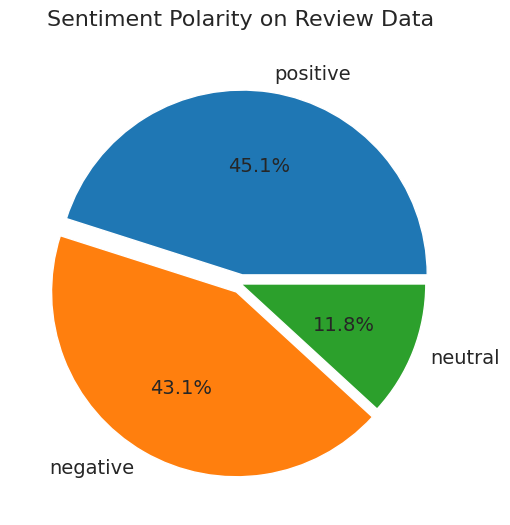

In [161]:
# Membuat objek gambar dan sumbu dengan ukuran (6, 6) inci
fig, ax = plt.subplots(figsize=(6, 6))

# Mengambil jumlah data polaritas sentimen dari DataFrame 'clean_df' dan menyumpannya dalam list sizes
sizes = [count for count in clean_df['polarity'].value_counts()]

# Mengambil label atau kategori sentimen dari DataFrame 'clean_df' dan menyumpannya dalam list labels
labels = list(clean_df['polarity'].value_counts().index)

# Menentukan seberapa jauh potongan dari pie chart akan ditarik (0.05 artinya potongan pertama dan kedua akan sedikit terpisah)
explode = (0.05, 0.05, 0)

# Membuat pie chart dengan data 'sizes' dan 'labels' dan 'explodes' yang telah ditentukan
ax.pie(
    x=sizes,
    labels=labels,
    explode=explode,
    autopct='%1.1f%%',
    textprops={'fontsize': 14},
)

# Memberikan judul pada pie chart
ax.set_title('Sentiment Polarity on Review Data', fontsize=16, pad=20)

# Menampilkan pie chart
plt.show()

## Label Exploration

In [162]:
def generate_tweets(polarity):
    # Mengatur opsi tampilan Pandas agar kolom dapat menapilkan teks hingga 3000 karakter
    pd.set_option('display.max_colwidth', 3000)

    # Membuat DataFrame baru 'tweets_df' yang hanya berisi tweet dengan polaritas yand ditentukan melalui parameter
    tweets_df = clean_df[clean_df['polarity'] == polarity]

    # Memilih kolom-kolom tertentu dari DataFrame tweets_df
    tweets_df = tweets_df[['text_final', 'polarity', 'polarity_score', 'text_stopwords']]

    # Mengurutkan DataFrame teweets_df berdasarkan 'polarity_score' secara descending
    tweets_df = tweets_df.sort_values(by='polarity_score', ascending=False)

    # Mengatur ulamg indeks DataFrame agar dimulai dari 0
    tweets_df = tweets_df.reset_index(drop=True)

    # Menambahkan 1 ke semua indeks DataFrame
    tweets_df.index += 1
    return tweets_df

In [163]:
def show_wordcloud_from_tweets(tweets, title):
    # Membuat string kosong untuk mengumpulkan kata dari teks yang sudah dibersihkan
    list_words = ""

    # Iterasi setiap tweet
    for tweet in tweets:
        # Iterasi setiap kata dalam tweet
        for word in tweet:
            # Menambahkan kata ke dalam list_words
            list_words += word + " "

    # Membuat objek WordCloud dengan parameter tertentu
    workcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

    # Membuat gambar dan sumbu untuk menmpikan word cloud
    fig, ax = plt.subplots(figsize=(8, 6))

    # Menetapkan judul untuk word cloud
    ax.set_title(title, fontsize=18)

    # Mematikan grid pada sumbu
    ax.grid(False)

    # Menampilkan word cloud dalam gambar
    ax.imshow(workcloud)

    # Mengatur layout gambar
    fig.tight_layout(pad=0)

    # Menyembunyikan sumbu pada word cloud
    ax.axis("off")

    # Menampikan word cloud
    plt.show()

In [164]:
# Menyiapkan positive tweets
positive_tweets = generate_tweets('positive')

# Menyiapkan negative tweets
negative_tweets = generate_tweets('negative')

# Menyiapakan netral tweets
neutral_tweets = generate_tweets('neutral')

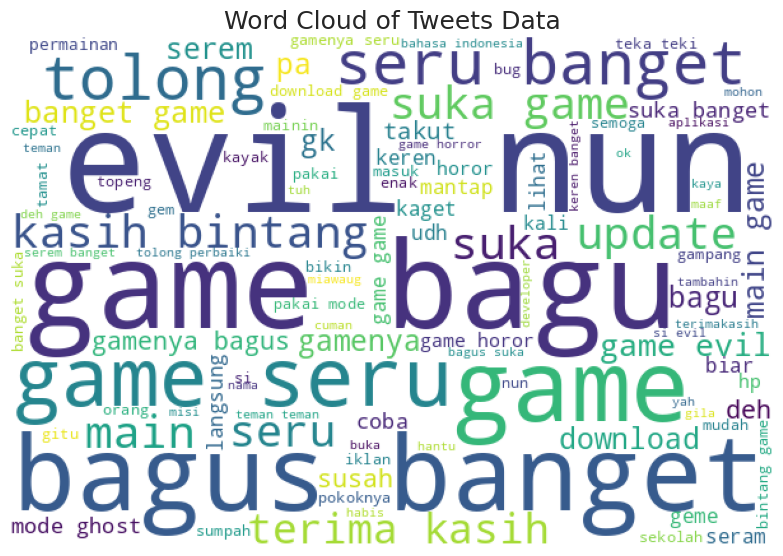

In [165]:
# Menampikan semua kata
show_wordcloud_from_tweets(clean_df["text_stopwords"], title="Word Cloud of Tweets Data")

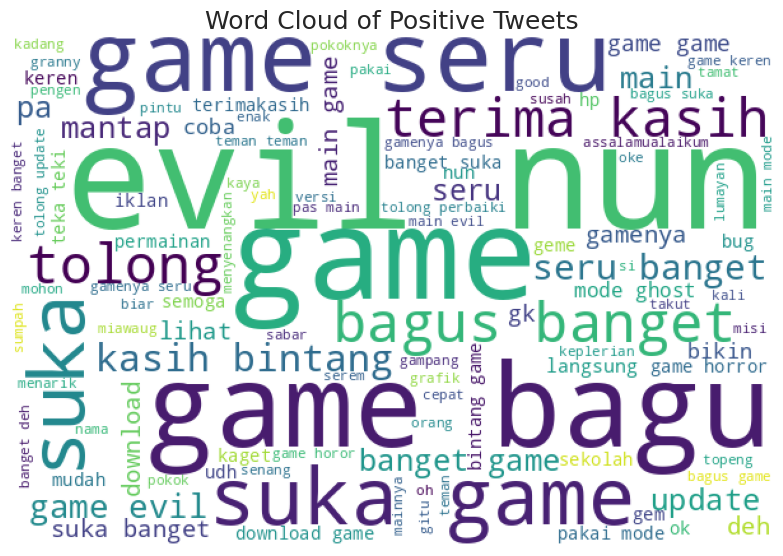

In [166]:
# Menampikan word cloud positif
show_wordcloud_from_tweets(positive_tweets['text_stopwords'], title="Word Cloud of Positive Tweets")

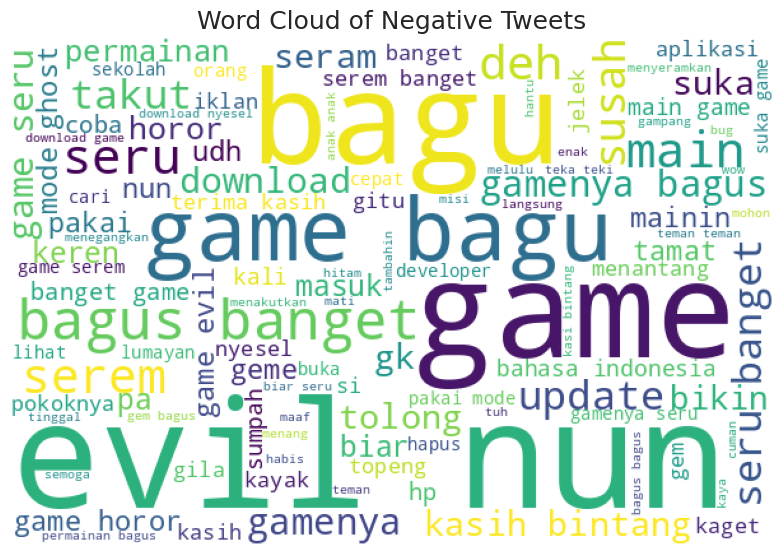

In [167]:
# Menampilkan word cloud negatif
show_wordcloud_from_tweets(negative_tweets['text_stopwords'], title="Word Cloud of Negative Tweets")

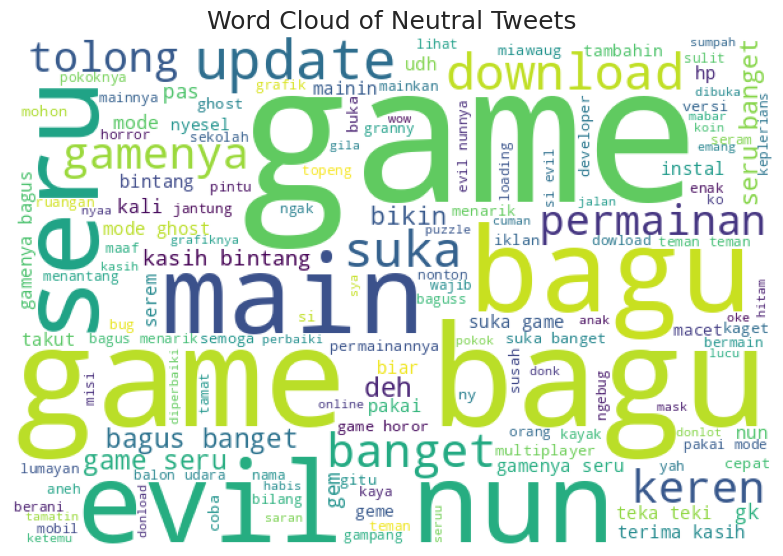

In [168]:
# Menampilkan word cloud netral
show_wordcloud_from_tweets(neutral_tweets['text_stopwords'], title="Word Cloud of Neutral Tweets")

## Feature Extraction, Splitting Data, and Modeling

In [169]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = clean_df['text_final']
y = clean_df['polarity']

### Experiment 1 (SVM, TF-IDF, 80/20)

In [170]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=5, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstra
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,ambil,anak,aplikasi,assalamualaikum,ayo,bagus,baguss,bahasa,balon,bang,...,tunggu,udara,udh,ulang,update,versi,wajib,wow,yah,youtube
0,0.0,0.0,0.0,0.0,0.0,0.090963,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.160553,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.480804,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.107320,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.336046,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.581396,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [171]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [172]:
# Membuat objek model SVM
svm = SVC()

# Melatih model SVM pada data pelatihan
svm.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM
accuracy_score_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_score_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi
print(f"SVM - accuracy_train: {accuracy_score_train_svm:.2f} ")
print(f"SVM - accuracy_test: {accuracy_score_test_svm:.2f}", )

SVM - accuracy_train: 0.86 
SVM - accuracy_test: 0.79


### Experiment 2 (RF, BoW, 80/20)

In [174]:
# Inisialisasi object CountVectorizer
count_vectorizer = CountVectorizer(max_features=200, min_df=5, max_df=0.8)

# Ekstraksi fitur dengan CountVectorizer
bow_matrix = count_vectorizer.fit_transform(X)

# Konversi hasil ekstra
features_df = pd.DataFrame(bow_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,ambil,anak,aplikasi,assalamualaikum,ayo,bagus,baguss,bahasa,balon,bang,...,tunggu,udara,udh,ulang,update,versi,wajib,wow,yah,youtube
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [176]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(bow_matrix, y, test_size=0.2, random_state=42)

In [177]:
# Mambuat objek model Random Forest
random_forest = RandomForestClassifier()

# Melatih model Random Forest pada data pelatihan
random_forest.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = random_forest.predict(X_train.toarray())
y_pred_test_rf = random_forest.predict(X_test.toarray())

# Menghitung nilai akurasi dari model Random Forest
accuracy_score_train_rf = accuracy_score(y_pred_train_rf, y_train)
accuracy_score_test_rf = accuracy_score(y_pred_test_rf, y_test)

# Menampilkan nilai akurasi
print(f"Random Forest - accuracy_train: {accuracy_score_train_rf:.2f}")
print(f"Random Forest - accuracy_test: {accuracy_score_test_rf:.2f}")

Random Forest - accuracy_train: 0.97
Random Forest - accuracy_test: 0.76


### Experiment 3 (NB, TF-IDF, 80/20)

In [203]:
# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=200, min_df=5, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# Konversi hasil ekstraksi
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

# Menampilkan hasil ekstraksi fitur
features_df

,ambil,anak,aplikasi,assalamualaikum,ayo,bagus,baguss,bahasa,balon,bang,...,tunggu,udara,udh,ulang,update,versi,wajib,wow,yah,youtube
0,0.0,0.0,0.0,0.0,0.0,0.090963,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.160553,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.480804,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.107320,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.336046,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11996,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11997,0.0,0.0,0.0,0.0,0.0,0.581396,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
11998,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [204]:
# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [206]:
# Membuat objeck model Naive Bayes (MyultinomialNB)
naive_bayes = MultinomialNB()

# melatiham model Naive Bayes pada data pelatihan
naive_bayes.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_nb = naive_bayes.predict(X_train.toarray())
y_pred_test_nb = naive_bayes.predict(X_test.toarray())

# Evaluasi akurasi model Naive Bayes
accuracy_train_nb = accuracy_score(y_pred_train_nb, y_train)
accuracy_test_nb = accuracy_score(y_pred_test_nb, y_test)

# Menampilkan nilai akurasi
print(f"Naive Bayes - accuracy_train: {accuracy_train_nb:.2f}")
print(f"Naive Bayes - accuracy_test: {accuracy_test_nb:.2f}")

Naive Bayes - accuracy_train: 0.74
Naive Bayes - accuracy_test: 0.73
